<a href="https://colab.research.google.com/github/thekhan314/CovidBrazilMod3/blob/master/COVID_REDUX_last_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtain


Lets start by importing all our libraries

In [1]:
from khantools import *
import pandas as pd
import numpy as np

import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
import operator as operator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

sns.set_style("dark")

C:\Users\umark\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


Here are some custom functions I wrote to help with data analysis

In [2]:
# Evaluate empty columns
def cols_with_data(dataframe,threshold,plot=False,axis=0):
    ''' returns a series with all columns that are filled to at least threshold percentage or higher'''
    
    counts = dataframe.count(axis=axis).sort_values()
    
    if axis == 0: 
        counts = counts/len(dataframe)
    else:
        counts = counts/len(dataframe.columns)
        
    non_zero_cols = counts[counts >= threshold ]
    
    if plot == True:
        fig,ax = plt.subplots(figsize=(40,40))
        ax.plot(non_zero_cols.index,non_zero_cols)
        fig.set_size_inches(6,9)
        fig.show()
        print("Features left:{}".format(len(non_zero_cols)))
    return non_zero_cols

def value_counts (df,value, oper):
    ''' takes in a datframe of float values, returns count of zero values '''
    dict = {}
    
    ops = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '=': operator.eq}
    
    for col in df.columns:
        matches = sum(ops[oper](df[col],value))
        
        dict[col] = matches
    
    df = pd.Series(dict)
    return df


Lets import the data and run a preliminary report

In [3]:
df = pd.read_excel('dataset.xlsx')
report_prelim = report1(df,5)
display(report_prelim)

,type,% empty,unique values,1nth_value,1nth_value_%,2nth_value,2nth_value_%,3nth_value,3nth_value_%,4nth_value,4nth_value_%,5nth_value,5nth_value_%
"Patient addmited to intensive care unit (1=yes, 0=no)",int64,0.00,2,0,99.27,1,0.73,NaN,NaN,NaN,NaN,NaN,NaN
"Patient addmited to semi-intensive unit (1=yes, 0=no)",int64,0.00,2,0,99.11,1,0.89,NaN,NaN,NaN,NaN,NaN,NaN
"Patient addmited to regular ward (1=yes, 0=no)",int64,0.00,2,0,98.60,1,1.40,NaN,NaN,NaN,NaN,NaN,NaN
SARS-Cov-2 exam result,object,0.00,2,negative,90.11,positive,9.89,NaN,NaN,NaN,NaN,NaN,NaN
Parainfluenza 2,object,76.05,1,not_detected,23.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bordetella pertussis,object,76.05,2,not_detected,23.92,detected,0.04,NaN,NaN,NaN,NaN,NaN,NaN
Parainfluenza 1,object,76.05,2,not_detected,23.90,detected,0.05,NaN,NaN,NaN,NaN,NaN,NaN
CoronavirusOC43,object,76.05,2,not_detected,23.81,detected,0.14,NaN,NaN,NaN,NaN,NaN,NaN
Chlamydophila pneumoniae,object,76.05,2,not_detected,23.80,detected,0.16,NaN,NaN,NaN,NaN,NaN,NaN
Coronavirus229E,object,76.05,2,not_detected,23.80,detected,0.16,NaN,NaN,NaN,NaN,NaN,NaN


# Scrub

## Rename & Clean Columns

The names of some of the columns are a bit long and unwieldy. Lets rename these colums. 

Lets also use the patientId as the index for the dataframe. This will make sure we are are merging correctly down the line if needed. 

Let's convert the age_quant column to float. Lets also make lists of features that are floats and those that are objects, so we have lists of which features were intended to be continuous and categorical from the outset. 

Finally, lets convert the columns listing admission status to floats.

In [4]:
# Lets change the names of some columns to something easier to work with
new_names = {
    'Patient addmited to intensive care unit (1=yes, 0=no)':'intensive',
    'Patient addmited to semi-intensive unit (1=yes, 0=no)':'semi_int',
    'Patient addmited to regular ward (1=yes, 0=no)':'reg_ward',
    'SARS-Cov-2 exam result':'sars_cov2',
    'Patient age quantile':'age_quant',
    'Patient ID':'patient_id'
}

df = df.rename(columns=new_names)
df.set_index(keys='patient_id',inplace=True)

admission_features = ['intensive','semi_int','reg_ward']
df_features = df.drop(admission_features,axis=1)
orig_features = list(df_features.columns)
features = orig_features.copy()

# convert age_quant to float

df['age_quant'] = df['age_quant'].astype(float)

df_types = df.dtypes

float_features = list(df_types[df_types == 'float64'].index)
obj_features = list(df_types[df_types == 'object'].index)


for col in admission_features:
    df[col] = df[col].astype(float)
    

## Convert Categoricals

Lets take a closer look at the categorical features and transform them as needed

In [5]:
report2 = report1(df[obj_features],3).sort_values('unique values')
display(report2)

,type,% empty,unique values,1nth_value,1nth_value_%,2nth_value,2nth_value_%,3nth_value,3nth_value_%
Urine - Nitrite,object,99.98,1,not_done,0.02,NaN,NaN,NaN,NaN
Parainfluenza 2,object,76.05,1,not_detected,23.95,NaN,NaN,NaN,NaN
Urine - Hyaline cylinders,object,98.81,1,absent,1.19,NaN,NaN,NaN,NaN
Urine - Granular cylinders,object,98.78,1,absent,1.22,NaN,NaN,NaN,NaN
Urine - Yeasts,object,98.76,1,absent,1.24,NaN,NaN,NaN,NaN
Urine - Ketone Bodies,object,98.99,2,absent,0.99,not_done,0.02,NaN,NaN
Urine - Protein,object,98.94,2,absent,1.05,not_done,0.02,NaN,NaN
Urine - Esterase,object,98.94,2,absent,1.05,not_done,0.02,NaN,NaN
Urine - Urobilinogen,object,98.78,2,normal,1.20,not_done,0.02,NaN,NaN
Urine - Bile pigments,object,98.76,2,absent,1.22,not_done,0.02,NaN,NaN


Lets also drop all the features with only one value. They are all negative and dont seem to add much information.

Lets convert the binary categoricals to floats. 

For tests that have a 'not done' value, I will treat 'not done' as negative, since its safe to assume if the test wasnt done the doctor was expecting a negative anyways. 

Urine Aspect color and crystals I will drop. They dont sound too important, and dont comprise alot of rows.

Urine PH and Urine Leukocytes should be converted to float

In [6]:
binary_conversions = list(report2[report2['unique values'] == 2].index)
unary_conversions = list(report2[report2['unique values'] == 1].index)
ternary_reduction = ['Strepto A','Urine - Hemoglobin']
bad_features = ['Urine - Aspect','Urine - Color','Urine - Crystals']
conv_to_float = ['Urine - pH', 'Urine - Leukocytes']

for col in binary_conversions:
    df[col] = df[col].replace(['not_detected','negative','absent','normal'],0)
    df[col] = df[col].replace(['detected','positive','not_done'],1)
    df[col] = df[col].astype(float)
for col in ternary_reduction:
    df[col] = df[col].replace(['negative','absent','not_done'],0)
    df[col] = df[col].replace(['present','positive'],1)
    df[col] = df[col].astype(float)

df['sars_cov2'] = df['sars_cov2'].replace(['negative'],0)
df['sars_cov2'] = df['sars_cov2'].replace(['positive'],1)

df['Urine - pH'] = df['Urine - pH'].replace(['Não Realizado'],5.0)
df['Urine - pH'] = df['Urine - pH'].astype(float)

df['Urine - Leukocytes'] = df['Urine - Leukocytes'].replace('<1000',1000)
df['Urine - Leukocytes'] = df['Urine - Leukocytes'].astype(float)

#update our list of feature types to choose the right regression model later
bad_set = set(bad_features) | set(unary_conversions) | set(conv_to_float) 

features = list(set(features) - bad_set)  

obj_features = list( set(obj_features) - bad_set) 
float_features = list(set(features) - set(obj_features))


df.drop(list(bad_set),axis=1, inplace = True)


## Cull Rows

It seems that alot of rows just dont have alot of data. It will be problematic filliing these rows, and doing so will probably introduce noise to our model without adding much useful signal to it. Lets take a look at the distrubtion of rows by how many values they have missing

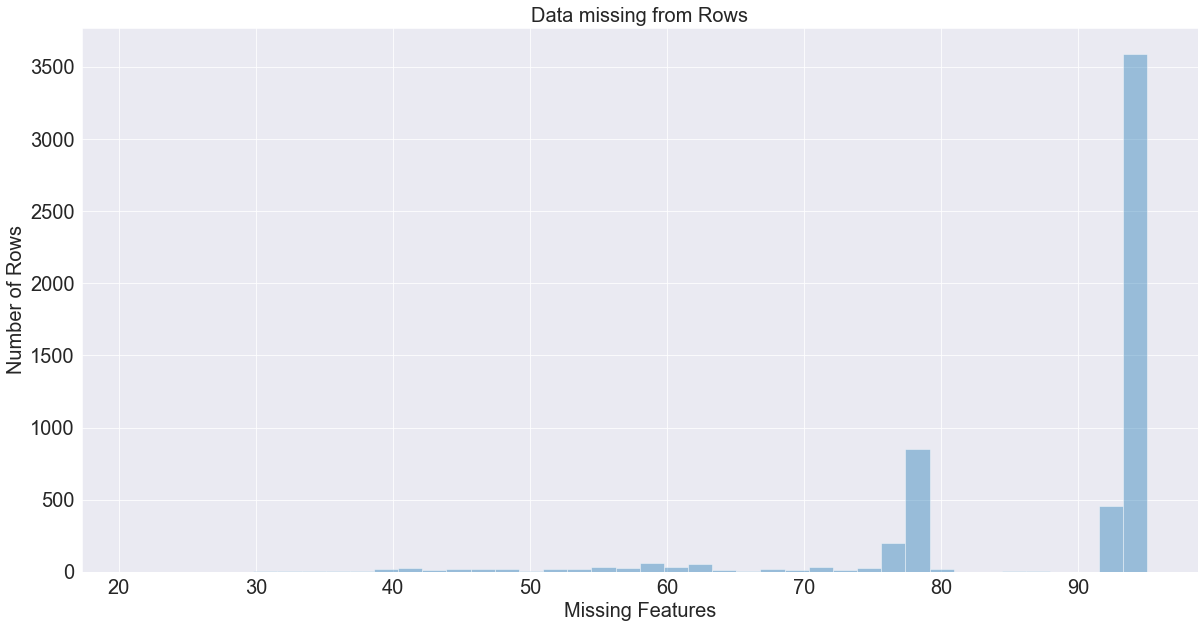

In [7]:
rows_empties = df.isnull().sum(axis=1).sort_values()

sns.set_style("darkgrid")
fig,ax = plt.subplots(figsize=(20,10))
sns.distplot(rows_empties,kde=False,ax = ax)
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)
ax.set_xlabel('Missing Features',fontsize=20)
ax.set_ylabel('Number of Rows',fontsize=20)
ax.set_title('Data missing from Rows',fontsize=20)
fig.savefig('row_cull')

It appears that a lot of rows are missing valeus for more than 90 features. These rows should be discarded. 

However, we want to retain any rows for patients who were admitted, since thats a minority class and we want to preserve as many of those values as we can. 

In [8]:
useful_rows = rows_empties[rows_empties < 90].index.to_list()
reg_wards= df[df['reg_ward'] == 1.0].index.to_list()
intensives = df[df['intensive'] == 1.0].index.to_list()
semis = df[df['semi_int'] == 1.0].index.to_list()
keepers = set(useful_rows) | set(reg_wards) | set(intensives) | set(semis) 

df = df.loc[keepers,:]

## Cull Columns

Now lets see which column have the most data and take out some of the more sparse ones

In [9]:
col_fill = cols_with_data(df,threshold=0).sort_values(ascending=False)
display(col_fill)
print(len(col_fill))

age_quant                                           1.000000
reg_ward                                            1.000000
semi_int                                            1.000000
intensive                                           1.000000
sars_cov2                                           1.000000
Respiratory Syncytial Virus                         0.839230
Parainfluenza 1                                     0.839230
Influenza A                                         0.839230
Metapneumovirus                                     0.839230
Bordetella pertussis                                0.839230
Inf A H1N1 2009                                     0.839230
CoronavirusOC43                                     0.839230
Parainfluenza 4                                     0.839230
Coronavirus229E                                     0.839230
Chlamydophila pneumoniae                            0.839230
Parainfluenza 3                                     0.839230
Coronavirus HKU1        

100


Lets get rid of all columns with less than 1.5% data. 

In [10]:
# all data: filled values in each column 
meaty_cols = col_fill[col_fill > 0.015].index.to_list()
df=df[meaty_cols]

Lets also remove get rid of the most common features after the ones that are 100 % full. These are the columns that are uniformly 24% full. These seem to be part of a standard battery of tests for different viruses. Somehow, I feel like these features wont contribute much to our predictions. 

In [11]:
col_fill = round(col_fill,2)
standard_tests = col_fill[col_fill == 0.84].index.to_list()
df.drop(standard_tests,axis=1,inplace=True)

# Explore

Im interested to see if features are populated at the same rates among admitted patients vs patients who have not been admitted. 

C:\Users\umark\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


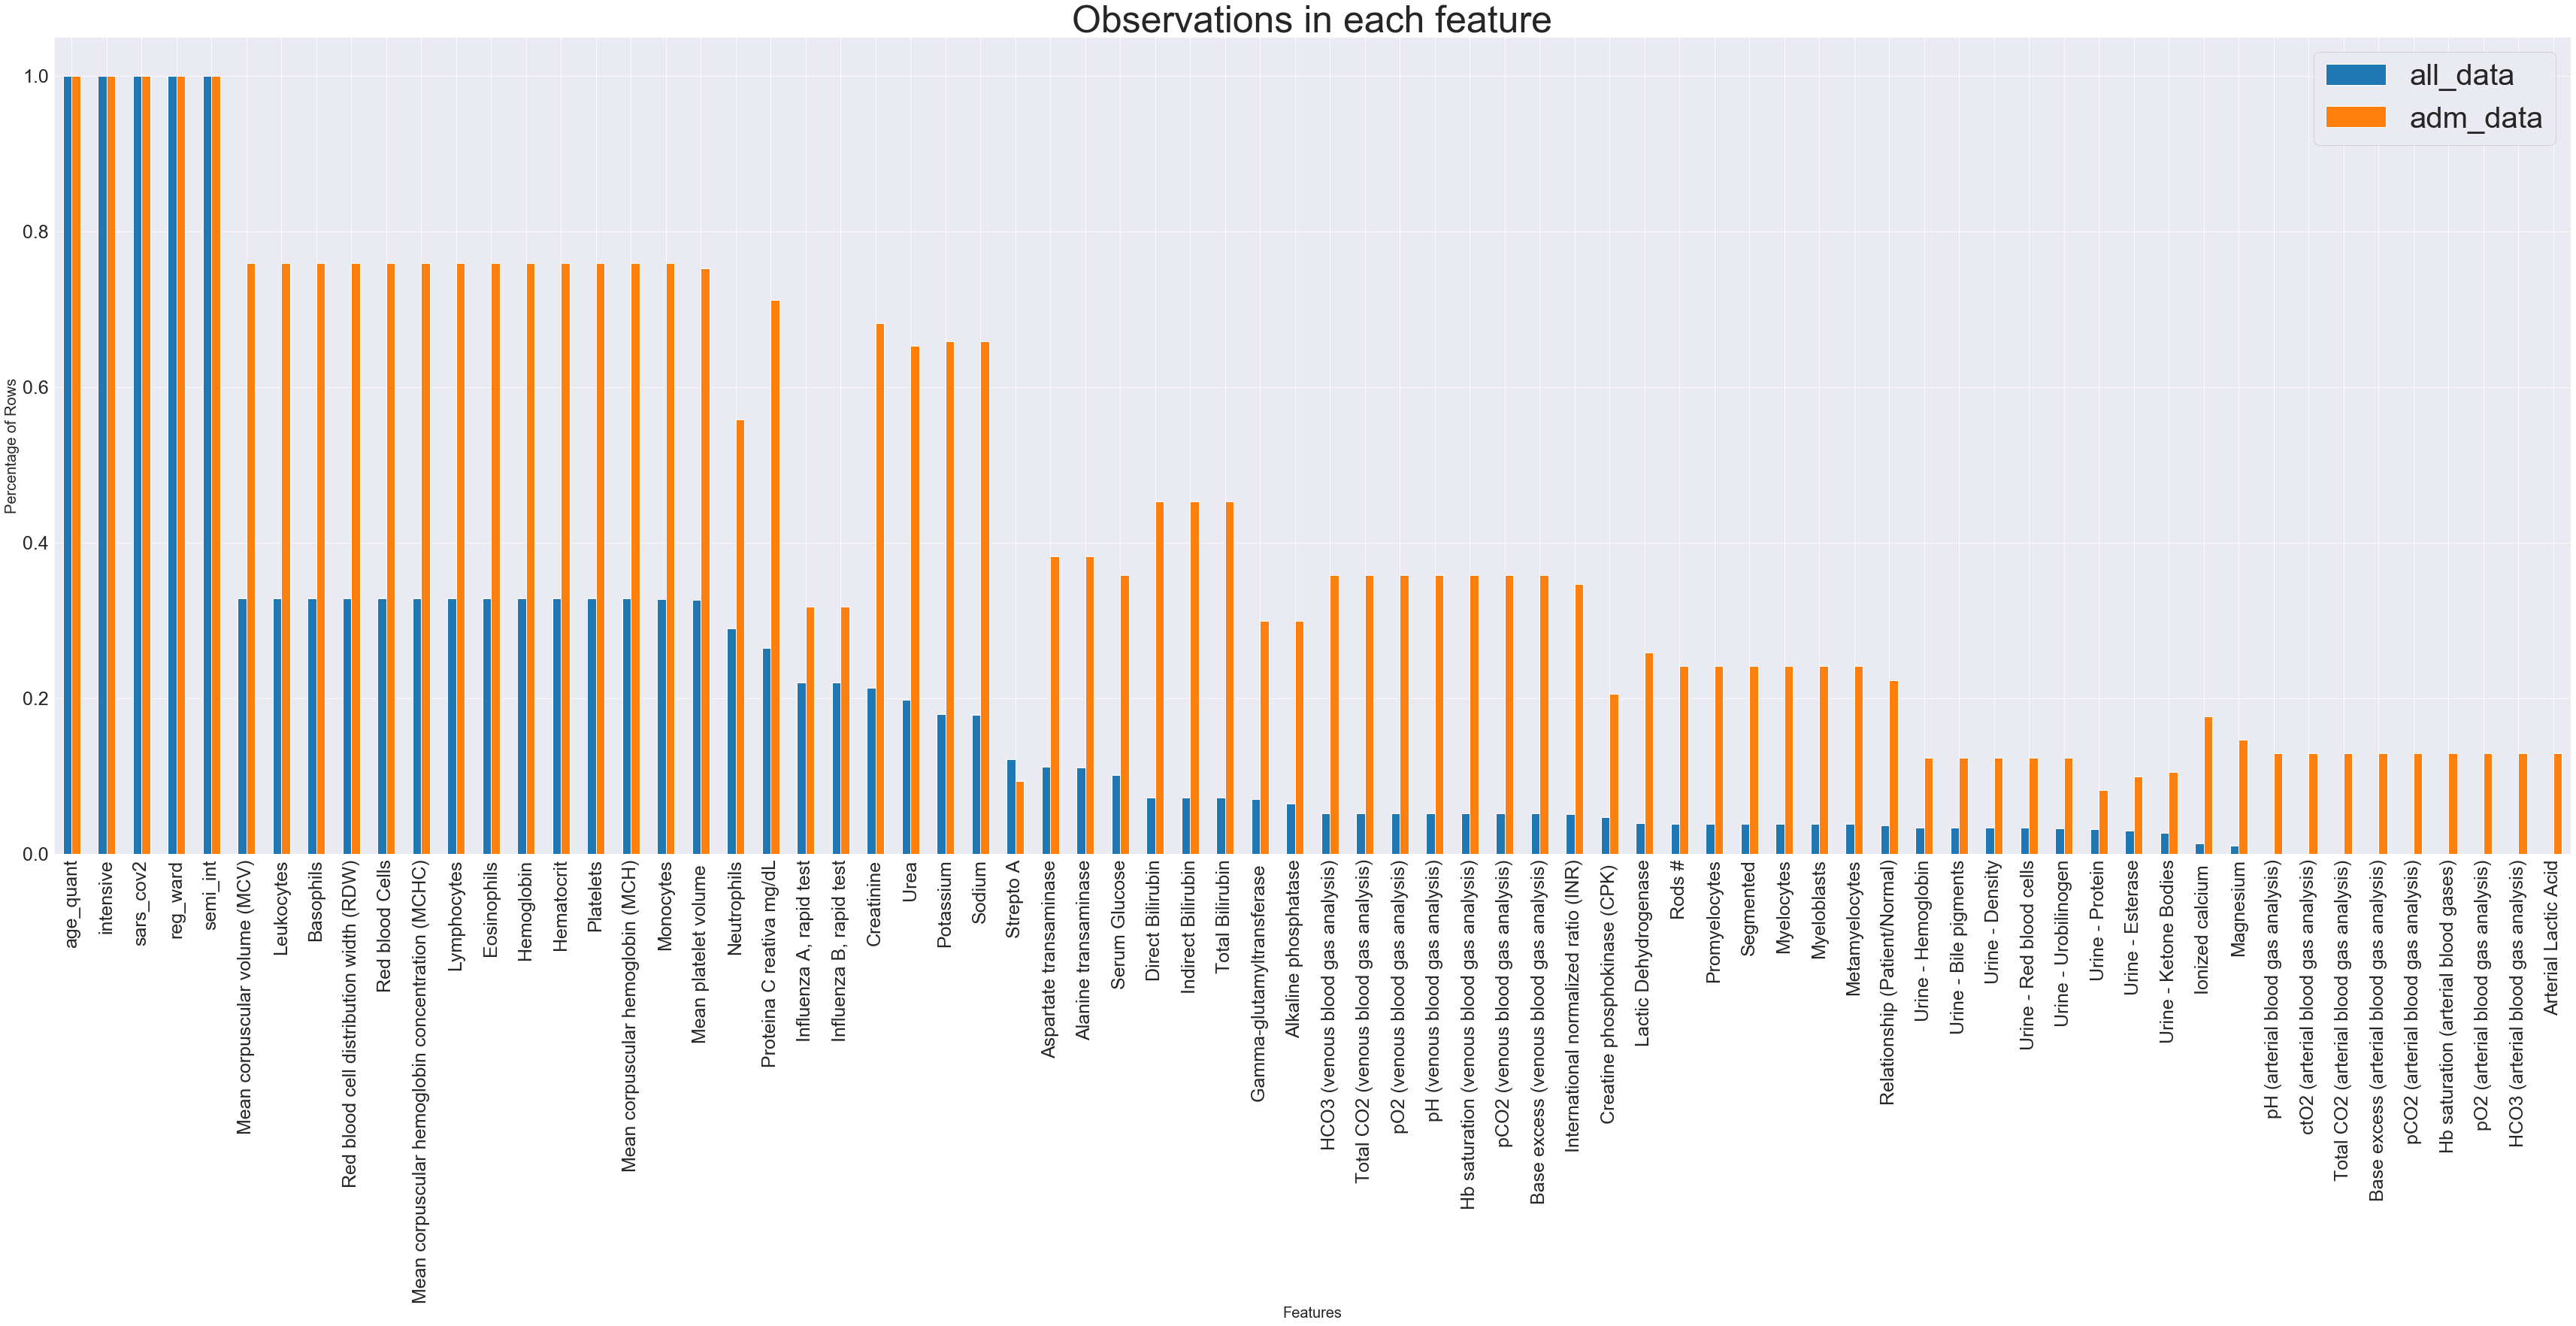

In [12]:
# split up df into traches (admitted, semi intensive et, etc. )

df_admit = df[df['reg_ward'] == 1]
df_semi = df[df['semi_int'] == 1]
df_intense = df[df['intensive'] == 1]

df_hosp = pd.concat([df_admit,df_semi,df_intense])
df_not_adm = df[~df.index.isin(df_hosp.index)]

adm_pats = set(df_admit.index)
semi_pats = set(df_semi.index)
intense_pats = set(df_intense.index)

semi_pats.issubset(adm_pats)
semi_not_admitted = list(np.setdiff1d(semi_pats,adm_pats)[0])

intense_pats.issubset(adm_pats)
intense_not_admitted = list(np.setdiff1d(intense_pats,adm_pats)[0])

empties = cols_with_data(df_not_adm,threshold=0.01).sort_values(ascending=False)
adm_highest_feats = cols_with_data(df_hosp,threshold=0.01).sort_values(ascending=False)
merged =pd.concat([empties.rename('all_data'),adm_highest_feats.rename('adm_data')],axis=1)

fig,ax = plt.subplots(figsize=(60,20))
merged.plot(kind='bar',ax=ax)
ax.tick_params(axis='x',labelsize=25)
ax.tick_params(axis='y',labelsize=25)
ax.legend(prop={'size':40})
ax.set_xlabel('Features',fontsize=20)
ax.set_ylabel('Percentage of Rows',fontsize=20)
ax.set_title('Observations in each feature',fontsize=50)
fig.show()
fig.savefig('feature_fills',bbox_inches = 'tight')



It looks as if people who have been admitted are more likely to be tested, which is about what we would expect. But the ranking of most often adminstered tests to least often administered tests seems to be very similar. 

## Fill Empties

Now lets fill the empty values in our dataframe. 

We are missing alot of data. I think the best way to fill the remaing data is to use regression to extrapolate unknown data from known data. 

We will start by using the features which are fully filled to predict the values of the features with the next highest amount of data in it. Once we have predicted values for that feature, we will add it to the list of fully filled features and incorporate it as a predictor to fill the features with the next highest amount of data in it and so on. In this way, we will try to leverage known data to the maximum in order to fill missing data. 

In [13]:
full_cols = cols_with_data(df,1)
full_feats = list(full_cols.index)

unfull_feats = list(df.drop(full_feats,axis=1).columns)

In [14]:
filled_feats = full_feats.copy()

for feature in unfull_feats:
    df_vals_present = df.loc[df[feature].notnull()]
    
    X = df_vals_present[filled_feats]
    y = df_vals_present[feature]
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    if feature in float_features:
        pipe = Ridge(alpha=0.5)
       
        
    elif feature in obj_features:
        
        pipe = LogisticRegression(C=1e5, solver='lbfgs',class_weight='balanced',max_iter=10000)
        
    
    pipe.fit(X,y)
    
    df_predictors = df.loc[df[feature].isna()][filled_feats]
    y_hat = pipe.predict(df_predictors)
    
    df.loc[df[feature].isna(),feature] = y_hat
    
    filled_feats.append(feature)


Currently, we have three columns that reflect a patients admitted status: reg_ward, semi_intensive or intensive. The value in column is 0 or 1 depending on the patients admission status. Only one of these three can be 1 at a time, meaning a person can only have one status at a time. If all three are 0, they are not admitted. 

We will unify these three features into one feature, which will serve as our target feature. The value will be 'reg_war','semi_intensive' or 'intensive' if one of those features i 1. at the end, all NaNs in the new column with be replaced with 'not admitted'.

In [15]:
for feat in admission_features:
    df.loc[df[feat] == 1,'adm_status'] = feat

df['adm_status'].fillna(value='not_adm',inplace=True)
df = df.drop(columns=admission_features)

# Model

Lets begin modeling! We start by splitting the data into features and target, as well as train and test sets. 

In [16]:
X = df.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.30, random_state=42)

## Baseline Model 

For our baseline model, lets just fit a logistic regression model using gridsearch and get some preliminary predicitons. These should give us some insight into how to modify our data maybe, or our models themselves. 

C:\Users\umark\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

   intensive       1.00      0.50      0.67        16
     not_adm       0.94      0.99      0.96       425
    reg_ward       0.60      0.50      0.55        24
    semi_int       0.50      0.21      0.30        19

    accuracy                           0.92       484
   macro avg       0.76      0.55      0.62       484
weighted avg       0.90      0.92      0.90       484



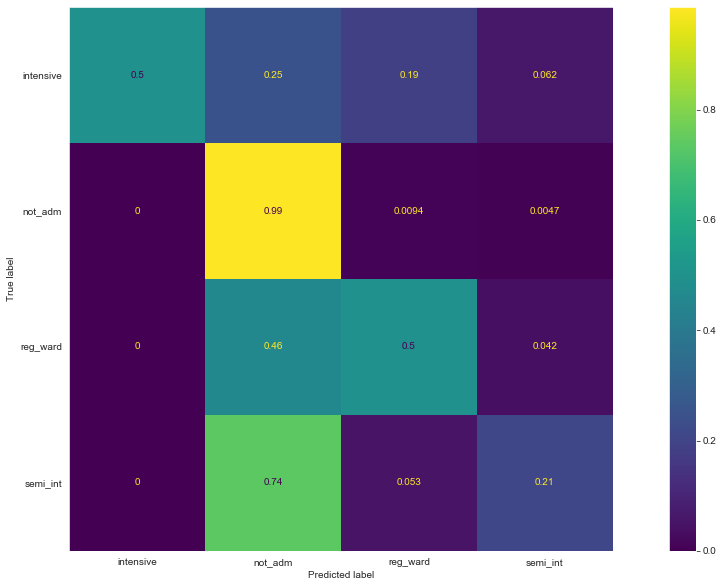

In [17]:
clf = LogisticRegression()

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)


fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(clf,X_test,y_test,ax=ax,normalize='true')

plt.grid(False)
print(classification_report(y_test,y_pred))


We can see that the performance for the minority labels is not that great. In this particular context we want recall to be as high as possible for the minority classes; we want to find as many people who are at high risk and might need intensive care as we can. Lets build a dictionary to gather the metrics we want the most, and keep track of model performance as we try different models. 

In [18]:
master_dict = {}

In [19]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'base_clf'

model_type = 'Logistic'

desc = 'Base clasifier', 

weight = 'none'

params = 'default'

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

### ROC Curves by label

Lets look at the ROC curves to see if our performance is any better than random guessing

In [20]:
X = df.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

label_list = df['adm_status'].value_counts().index.to_list()
y = label_binarize(df['adm_status'],label_list)

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.30, random_state=42)

C:\Users\umark\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


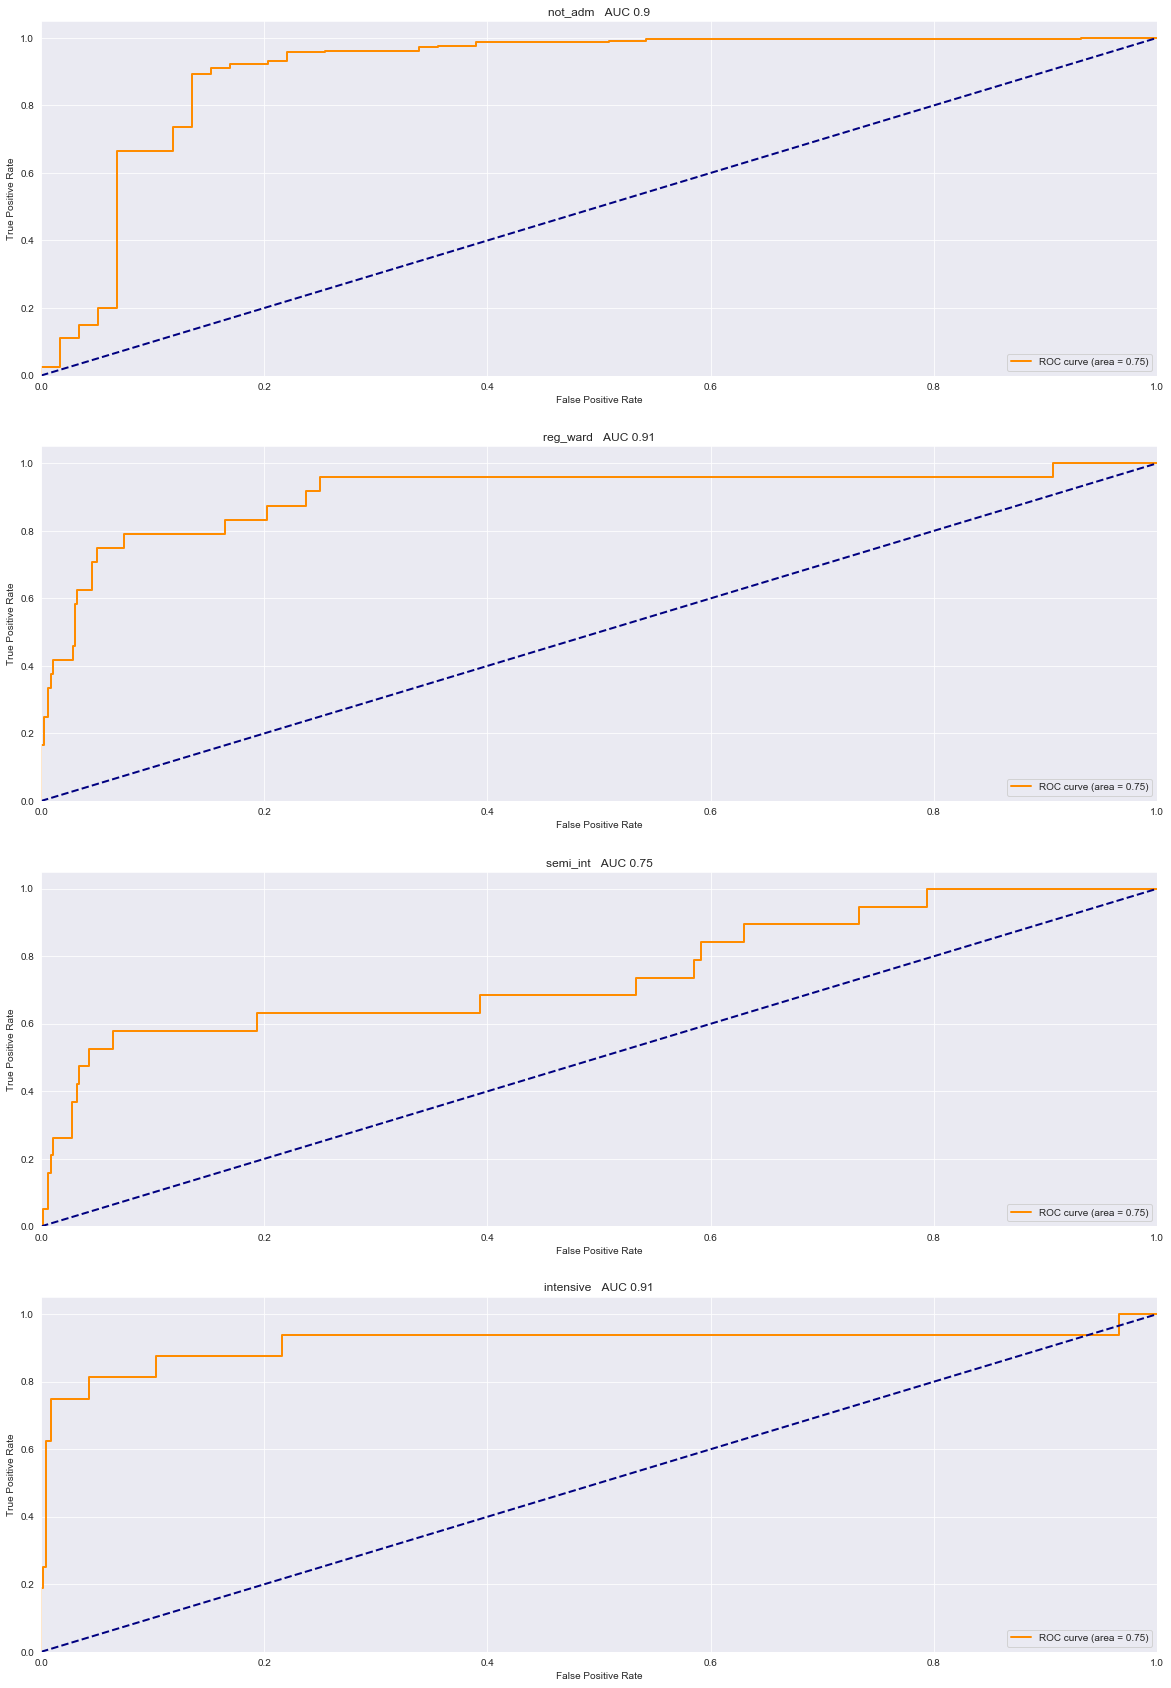

In [21]:
estimator = LogisticRegression()

clf = OneVsRestClassifier(estimator)

clf.fit(X_train,y_train)

y_score = clf.decision_function(X_test)
y_pred = clf.predict(X_test)
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig,ax = plt.subplots(len(label_list),figsize=(20,30))

for i in range(0,len(label_list)):
    ax[i].plot(fpr[i], tpr[i], color='darkorange',
            lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    ax[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.05])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].set_title(label_list[i] + '   AUC {}'.format(round(roc_auc[i],2)))
    ax[i].legend(loc="lower right")
    



### Relabel and retry

Lets use regression to classify semi_ints as either reg_Ward or intensive.

In [22]:
df2 = df.copy()

semi_indexes = df2.loc[df2['adm_status'] == 'semi_int',:].index.to_list()

df_train = df2.drop(semi_indexes,axis=0)

X = df_train.drop('adm_status',axis=1)
y = df_train['adm_status']

X_test = df2.loc[semi_indexes,:].drop('adm_status',axis=1)

weight_dict = {
    'not_adm': 1,
    'reg_ward': 10,
    'intensive': 70
}

clf = LogisticRegression(C=1000,max_iter=100,solver='liblinear',class_weight=weight_dict)

clf.fit(X,y)

y_predict = clf.predict(X_test)

df2.loc[semi_indexes,'adm_status'] = y_predict

In [23]:
X = df2.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df2['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.30, random_state=42)


C:\Users\umark\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


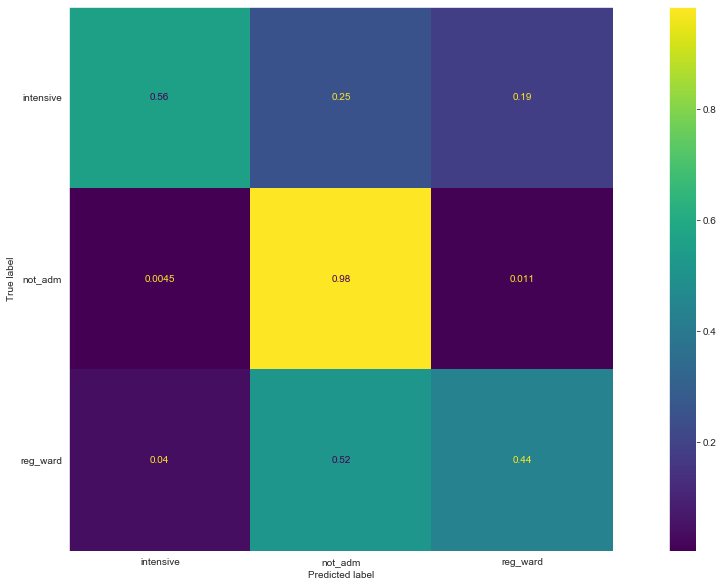

In [24]:
clf = LogisticRegression()

clf.fit(X_train,y_train)

fig,ax = plt.subplots(figsize=(20,10))
plt.grid(False)
base_cf_plot = plot_confusion_matrix(clf,X_test,y_test,ax=ax,normalize='true')

y_pred = clf.predict(X_test)

In [25]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'base_semi_refilledf'

model_type = 'Logistic'

desc = 'refilled Semit Int using regression', 

weight = 'none'

params = 'Default'

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.666667,0.5000,1.00,0.545455,0.50,0.600000
base_semi_refilledf,0.642857,0.5625,0.75,0.500000,0.44,0.578947


## Logistic Regresison

### Weights Dictionary

Lets try a more expanded range of Logistic Regression parameters. Lets use explicit weight dictionaries, and lets try to optimize for the recall of intensive in our gridsearch.

In [26]:
weights_dict = [{
    'not_adm':1,
    'reg_ward':20,
    'intensive':60
},{
    'not_adm':1,
    'reg_ward':15,
    'intensive':50
},{
    'not_adm':1,
    'reg_ward':30,
    'intensive':60
},{
    'not_adm':1,
    'reg_ward':40,
    'intensive':100
}
]

In [27]:
clf = LogisticRegression()


params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
    'class_weight':weights_dict
}

scorer = make_scorer(recall_score, labels=['intensive'],average = 'macro')

gs_logistic = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_logistic.fit(X_train,y_train)

clf = gs_logistic.best_estimator_

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)

print(class_report_1)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s


              precision    recall  f1-score   support

   intensive       0.34      0.75      0.47        16
     not_adm       0.99      0.84      0.91       443
    reg_ward       0.25      0.72      0.37        25

    accuracy                           0.83       484
   macro avg       0.53      0.77      0.58       484
weighted avg       0.93      0.83      0.87       484



[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   16.8s finished
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

In [28]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'logis_recall_dict_weight'

model_type = 'Logistic - Highest Recall'

desc = 'used weights dictionaries in grid search to address imbalance', 

weight = 'Dictionary'

params = gs_logistic.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.666667,0.5000,1.000000,0.545455,0.50,0.600000
base_semi_refilledf,0.642857,0.5625,0.750000,0.500000,0.44,0.578947
logis_recall_dict_weight,0.470588,0.7500,0.342857,0.371134,0.72,0.250000


Let's try maximizing for the f1 score for intensive instead. 

In [29]:
clf = LogisticRegression()


params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
    'class_weight':weights_dict
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_logistic = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_logistic.fit(X_train,y_train)

clf = gs_logistic.best_estimator_

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)

print(class_report_1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   13.5s finished


              precision    recall  f1-score   support

   intensive       0.80      0.75      0.77        16
     not_adm       1.00      0.99      0.99       443
    reg_ward       0.83      0.96      0.89        25

    accuracy                           0.98       484
   macro avg       0.87      0.90      0.89       484
weighted avg       0.98      0.98      0.98       484



In [30]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'logis_f1_dict_weight'

model_type = 'Logistic - Highest F1'

desc = 'used weights dictionaries in grid search to address imbalance, scored with f1', 

weight = 'Dictionary'

params = gs_logistic.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.666667,0.5000,1.000000,0.545455,0.50,0.600000
base_semi_refilledf,0.642857,0.5625,0.750000,0.500000,0.44,0.578947
logis_recall_dict_weight,0.470588,0.7500,0.342857,0.371134,0.72,0.250000
logis_f1_dict_weight,0.774194,0.7500,0.800000,0.888889,0.96,0.827586


### SMOTE

Now lets use SMOTE to reblance our classes and see if it does any better.

In [31]:
smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.4s finished
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


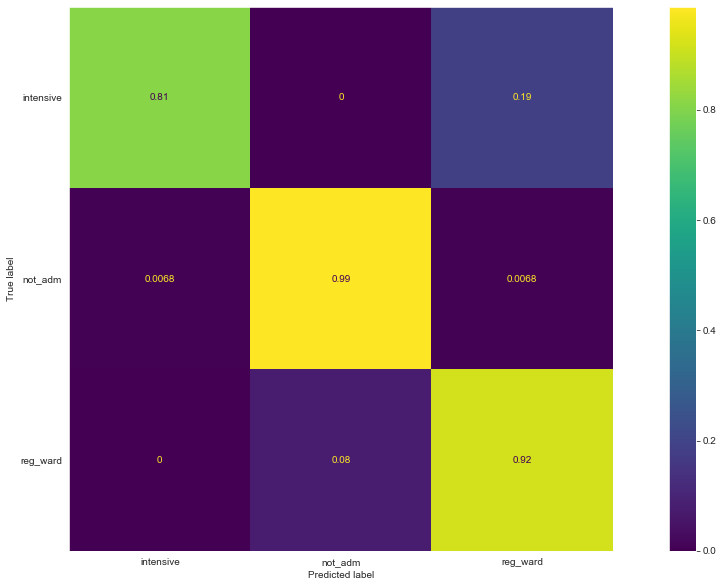

In [32]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

scorer = make_scorer(recall_score, labels=['intensive'],average = 'macro')
gs_logistic = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_logistic.fit(X_train_smote,y_train_smote)

base_clf = gs_logistic.best_estimator_

base_clf.fit(X_train_smote,y_train_smote)

fig,ax = plt.subplots(figsize=(20,10))
plt.grid(False)
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

y_pred = base_clf.predict(X_test)


In [33]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'logis_recall_smote'

model_type = 'Logistic - Highest Recall'

desc = 'used SMOTE on the training sets, scored with recall', 

weight = 'SMOTE'

params = gs_logistic.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.666667,0.5000,1.000000,0.545455,0.50,0.600000
base_semi_refilledf,0.642857,0.5625,0.750000,0.500000,0.44,0.578947
logis_recall_dict_weight,0.470588,0.7500,0.342857,0.371134,0.72,0.250000
logis_f1_dict_weight,0.774194,0.7500,0.800000,0.888889,0.96,0.827586
logis_recall_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103


Much better performance! PRecision is still a tad low.Lets see if the best f1 returns better results.

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.4s finished
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


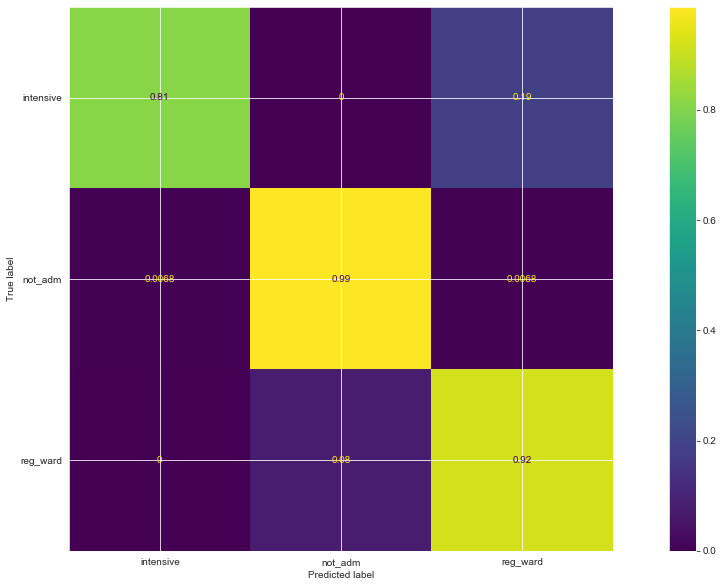

In [34]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')
gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_base.fit(X_train_smote,y_train_smote)

base_clf = gs_base.best_estimator_

base_clf.fit(X_train_smote,y_train_smote)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

y_pred = base_clf.predict(X_test)

In [36]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'logis_f1_smote'

model_type = 'Logistic - F1'

desc = 'used SMOTE on the training sets, scored with f1', 

weight = 'SMOTE'

params = gs_logistic.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.666667,0.5000,1.000000,0.545455,0.50,0.600000
base_semi_refilledf,0.642857,0.5625,0.750000,0.500000,0.44,0.578947
logis_recall_dict_weight,0.470588,0.7500,0.342857,0.371134,0.72,0.250000
logis_f1_dict_weight,0.774194,0.7500,0.800000,0.888889,0.96,0.827586
logis_recall_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
logis_f1_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103


## K Nearest Neighbors

Now lets try K- Nearest Neighbors

In [37]:
clf = KNeighborsClassifier()

params = {
    'n_neighbors': [5,10,15],
    'weights':['uniform','distance'],
    'algorithm':['auto'],
    'leaf_size':[5,10,20],
    'p':[1,2,3]
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_kneighb_class = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_kneighb_class.fit(X_train_smote,y_train_smote)

clf = gs_kneighb_class.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.1min finished


In [38]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'knn_f1_smote'

model_type = 'KNN - F1'

desc = 'KNN on SMOTE, scored with f1', 

weight = 'SMOTE'

params = gs_kneighb_class.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.666667,0.5000,1.000000,0.545455,0.50,0.600000
base_semi_refilledf,0.642857,0.5625,0.750000,0.500000,0.44,0.578947
logis_recall_dict_weight,0.470588,0.7500,0.342857,0.371134,0.72,0.250000
logis_f1_dict_weight,0.774194,0.7500,0.800000,0.888889,0.96,0.827586
logis_recall_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
logis_f1_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
knn_f1_smote,0.444444,0.5000,0.400000,0.305882,0.52,0.216667


## Decision Tree

In [39]:
clf = DecisionTreeClassifier()

params = {
    'criterion': ['entropy','gini'],
    'splitter':['best', 'random'],
    'max_depth':[i for i in np.linspace(1, 32, 8, endpoint=True)],
    'min_samples_split':[i for i in np.linspace(0.1, 1.0, 10, endpoint=True)],
    'min_samples_leaf':[i for i in np.linspace(0.1, 0.5, 5, endpoint=True)]
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_dec_tree = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_dec_tree.fit(X_train_smote,y_train_smote)

clf = gs_dec_tree.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)

print(class_report_1)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 4264 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 7864 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:  1.4min finished


              precision    recall  f1-score   support

   intensive       0.33      0.56      0.42        16
     not_adm       0.98      0.74      0.85       443
    reg_ward       0.14      0.68      0.24        25

    accuracy                           0.74       484
   macro avg       0.48      0.66      0.50       484
weighted avg       0.91      0.74      0.80       484



In [40]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'dec_tree_f1_smote'

model_type = 'Decision Tree - F1'

desc = 'Decision Tree on SMOTE, scored with f1', 

weight = 'SMOTE'

params = gs_dec_tree.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.666667,0.5000,1.000000,0.545455,0.50,0.600000
base_semi_refilledf,0.642857,0.5625,0.750000,0.500000,0.44,0.578947
logis_recall_dict_weight,0.470588,0.7500,0.342857,0.371134,0.72,0.250000
logis_f1_dict_weight,0.774194,0.7500,0.800000,0.888889,0.96,0.827586
logis_recall_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
logis_f1_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
knn_f1_smote,0.444444,0.5000,0.400000,0.305882,0.52,0.216667
dec_tree_f1_smote,0.418605,0.5625,0.333333,0.236111,0.68,0.142857


## Random Forest

In [41]:
clf = RandomForestClassifier()

params = {
    'criterion': ['entropy','gini'],
    'max_depth':[2,6,14,24,32],
    'min_samples_split':[1,2,3,4,5,6,7,8,9,10],
    'min_samples_leaf':[0.1,0.2,0.3,0.4,0.5]
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_random_forest = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_random_forest.fit(X_train_smote,y_train_smote)

clf = gs_random_forest.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  5.8min finished


In [42]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'rand_forest_f1_smote'

model_type = 'Random Forest - F1'

desc = 'Random Forest on SMOTE, scored with f1', 

weight = 'SMOTE'

params = gs_random_forest.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.666667,0.5000,1.000000,0.545455,0.50,0.600000
base_semi_refilledf,0.642857,0.5625,0.750000,0.500000,0.44,0.578947
logis_recall_dict_weight,0.470588,0.7500,0.342857,0.371134,0.72,0.250000
logis_f1_dict_weight,0.774194,0.7500,0.800000,0.888889,0.96,0.827586
logis_recall_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
logis_f1_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
knn_f1_smote,0.444444,0.5000,0.400000,0.305882,0.52,0.216667
dec_tree_f1_smote,0.418605,0.5625,0.333333,0.236111,0.68,0.142857
rand_forest_f1_smote,0.500000,0.7500,0.375000,0.229008,0.60,0.141509


## XGboost

In [43]:
import xgboost as xgb
clf = xgb.XGBClassifier( objective='multi:softmax', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10,scale_pos_weight=15)
clf.fit(X_train_smote,y_train_smote)

y_score = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_score)


print(class_report_1)

              precision    recall  f1-score   support

   intensive       0.64      0.56      0.60        16
     not_adm       0.96      0.92      0.94       443
    reg_ward       0.30      0.56      0.39        25

    accuracy                           0.89       484
   macro avg       0.64      0.68      0.65       484
weighted avg       0.92      0.89      0.90       484



In [44]:
clf = xgb.XGBClassifier()

param_grid = {
    "learning_rate": [0.01,0.05,0.5],
    'max_depth': [2,6,10],
    'min_child_weight': [1,10,100],
    'subsample': [0.5,0.75,1.0],
    'n_estimators': [5,20]
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_xgboost = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_xgboost.fit(X_train_smote,y_train_smote)

clf = gs_xgboost.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  2.5min finished


In [45]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'xgboostt_f1_smote'

model_type = 'XGBoost - F1'

desc = 'XGBOOST on SMOTE, scored with f1', 

weight = 'SMOTE'

params = gs_xgboost.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.666667,0.5000,1.000000,0.545455,0.50,0.600000
base_semi_refilledf,0.642857,0.5625,0.750000,0.500000,0.44,0.578947
logis_recall_dict_weight,0.470588,0.7500,0.342857,0.371134,0.72,0.250000
logis_f1_dict_weight,0.774194,0.7500,0.800000,0.888889,0.96,0.827586
logis_recall_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
logis_f1_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
knn_f1_smote,0.444444,0.5000,0.400000,0.305882,0.52,0.216667
dec_tree_f1_smote,0.418605,0.5625,0.333333,0.236111,0.68,0.142857
rand_forest_f1_smote,0.500000,0.7500,0.375000,0.229008,0.60,0.141509
xgboostt_f1_smote,0.666667,0.5625,0.818182,0.391304,0.36,0.428571


### Recall

In [46]:
clf = xgb.XGBClassifier()

param_grid = {
    "learning_rate": [0.01,0.05,0.5],
    'max_depth': [2,6,10],
    'min_child_weight': [1,10,100],
    'subsample': [0.5,0.75,1.0],
    'n_estimators': [5,20]
}

scorer = make_scorer(recall_score, labels=['intensive'],average = 'macro')

gs_xgboost = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_xgboost.fit(X_train_smote,y_train_smote)

clf = gs_xgboost.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  3.3min finished


In [47]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'xgboostt_recall_smote'

model_type = 'XGBoost - Recall'

desc = 'XGBOOST on SMOTE, scored with Recall', 

weight = 'SMOTE'

params = gs_xgboost.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.666667,0.5000,1.000000,0.545455,0.50,0.600000
base_semi_refilledf,0.642857,0.5625,0.750000,0.500000,0.44,0.578947
logis_recall_dict_weight,0.470588,0.7500,0.342857,0.371134,0.72,0.250000
logis_f1_dict_weight,0.774194,0.7500,0.800000,0.888889,0.96,0.827586
logis_recall_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
logis_f1_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
knn_f1_smote,0.444444,0.5000,0.400000,0.305882,0.52,0.216667
dec_tree_f1_smote,0.418605,0.5625,0.333333,0.236111,0.68,0.142857
rand_forest_f1_smote,0.500000,0.7500,0.375000,0.229008,0.60,0.141509
xgboostt_f1_smote,0.666667,0.5625,0.818182,0.391304,0.36,0.428571


## Support Vector Machines

In [48]:
clf = SVC()

params = {
    'C':[1,100,1000],
    'kernel':['linear','rbf'],
    'degree': [2,3,4],
    'gamma':['scale']
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')
gs_svc = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_svc.fit(X_train_smote,y_train_smote)

clf = gs_svc.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred,output_dict=True)
report = pd.DataFrame(class_report_1)
print(report)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.1s finished


           intensive     not_adm   reg_ward  accuracy   macro avg  \
precision  0.800000   0.953744    0.500000   0.931818  0.751248     
recall     0.500000   0.977427    0.400000   0.931818  0.625809     
f1-score   0.615385   0.965440    0.444444   0.931818  0.675090     
support    16.000000  443.000000  25.000000  0.931818  484.000000   

           weighted avg  
precision  0.925225      
recall     0.931818      
f1-score   0.926957      
support    484.000000    


In [49]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'gs_svc_f1_smote'

model_type = 'SVC - F1'

desc = 'SVC on SMOTE, scored with f1', 

weight = 'SMOTE'

params = gs_svc.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.666667,0.5000,1.000000,0.545455,0.50,0.600000
base_semi_refilledf,0.642857,0.5625,0.750000,0.500000,0.44,0.578947
logis_recall_dict_weight,0.470588,0.7500,0.342857,0.371134,0.72,0.250000
logis_f1_dict_weight,0.774194,0.7500,0.800000,0.888889,0.96,0.827586
logis_recall_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
logis_f1_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
knn_f1_smote,0.444444,0.5000,0.400000,0.305882,0.52,0.216667
dec_tree_f1_smote,0.418605,0.5625,0.333333,0.236111,0.68,0.142857
rand_forest_f1_smote,0.500000,0.7500,0.375000,0.229008,0.60,0.141509
xgboostt_f1_smote,0.666667,0.5625,0.818182,0.391304,0.36,0.428571


### Recall

In [50]:
clf = SVC()

params = {
    'C':[1,100,1000],
    'kernel':['linear','rbf'],
    'degree': [2,3,4],
    'gamma':['scale']
}

scorer = make_scorer(recall_score, labels=['intensive'],average = 'macro')
gs_svc = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_svc.fit(X_train_smote,y_train_smote)

gs_svc.best_score_
gs_svc.best_params_


clf = gs_svc.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)



Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.7s finished


In [51]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'gs_svc_recall_smote'

model_type = 'SVC - Recall'

desc = 'SVC on SMOTE, scored with Recall', 

weight = 'SMOTE'

params = gs_svc.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.666667,0.5000,1.000000,0.545455,0.50,0.600000
base_semi_refilledf,0.642857,0.5625,0.750000,0.500000,0.44,0.578947
logis_recall_dict_weight,0.470588,0.7500,0.342857,0.371134,0.72,0.250000
logis_f1_dict_weight,0.774194,0.7500,0.800000,0.888889,0.96,0.827586
logis_recall_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
logis_f1_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
knn_f1_smote,0.444444,0.5000,0.400000,0.305882,0.52,0.216667
dec_tree_f1_smote,0.418605,0.5625,0.333333,0.236111,0.68,0.142857
rand_forest_f1_smote,0.500000,0.7500,0.375000,0.229008,0.60,0.141509
xgboostt_f1_smote,0.666667,0.5625,0.818182,0.391304,0.36,0.428571


# Model Evaluation

## Best Model

Now lets see which of our models did the best. We will sort our report dataframe by highest f1 score for the 'intensive' category. 

In [52]:
rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

rep_df.sort_values(by=['intensive_f1','reg_ward_f1'],ascending=False,inplace=True)

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
logis_recall_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
logis_f1_smote,0.812500,0.8125,0.812500,0.851852,0.92,0.793103
logis_f1_dict_weight,0.774194,0.7500,0.800000,0.888889,0.96,0.827586
gs_svc_recall_smote,0.727273,0.7500,0.705882,0.730769,0.76,0.703704
base_clf,0.666667,0.5000,1.000000,0.545455,0.50,0.600000
xgboostt_f1_smote,0.666667,0.5625,0.818182,0.391304,0.36,0.428571
base_semi_refilledf,0.642857,0.5625,0.750000,0.500000,0.44,0.578947
xgboostt_recall_smote,0.642857,0.5625,0.750000,0.322581,0.40,0.270270
gs_svc_f1_smote,0.615385,0.5000,0.800000,0.444444,0.40,0.500000
rand_forest_f1_smote,0.500000,0.7500,0.375000,0.229008,0.60,0.141509


It appears that that the Logistic Regression model performed the best when used one data that had been resampled using SMOTE. Logistic Regression using a dictionary of weights did slightly better for the regular ward class, but as a higher cost to the performance of the intensive label. Since the intensive category is more important to get right, and since the decrease in performance for reg_ward using Logistic Regression and SMOTE is so small, lets settle on LogReg with SMOTE as our optimal model

## Feature Importance

Now lets see which features our optimal model found to be most important when making predicitons. 

In [53]:
params = master_dict['logis_recall_smotet']['params']
print(params)

{'C': 1000.0, 'class_weight': {'not_adm': 1, 'reg_ward': 30, 'intensive': 60}, 'max_iter': 10, 'solver': 'lbfgs'}


In [54]:
class_weights = {'not_adm': 1, 'reg_ward': 20, 'intensive': 60}

best_clf = LogisticRegression(C= 1000.0, max_iter= 100, solver= 'liblinear',class_weight=class_weights)

In [55]:
best_clf.fit(X_train,y_train)

y_pred = best_clf.predict(X_test)

clas_rep = classification_report(y_test,y_pred)
print(clas_rep)



              precision    recall  f1-score   support

   intensive       0.81      0.81      0.81        16
     not_adm       0.99      0.99      0.99       443
    reg_ward       0.85      0.92      0.88        25

    accuracy                           0.98       484
   macro avg       0.89      0.91      0.90       484
weighted avg       0.98      0.98      0.98       484



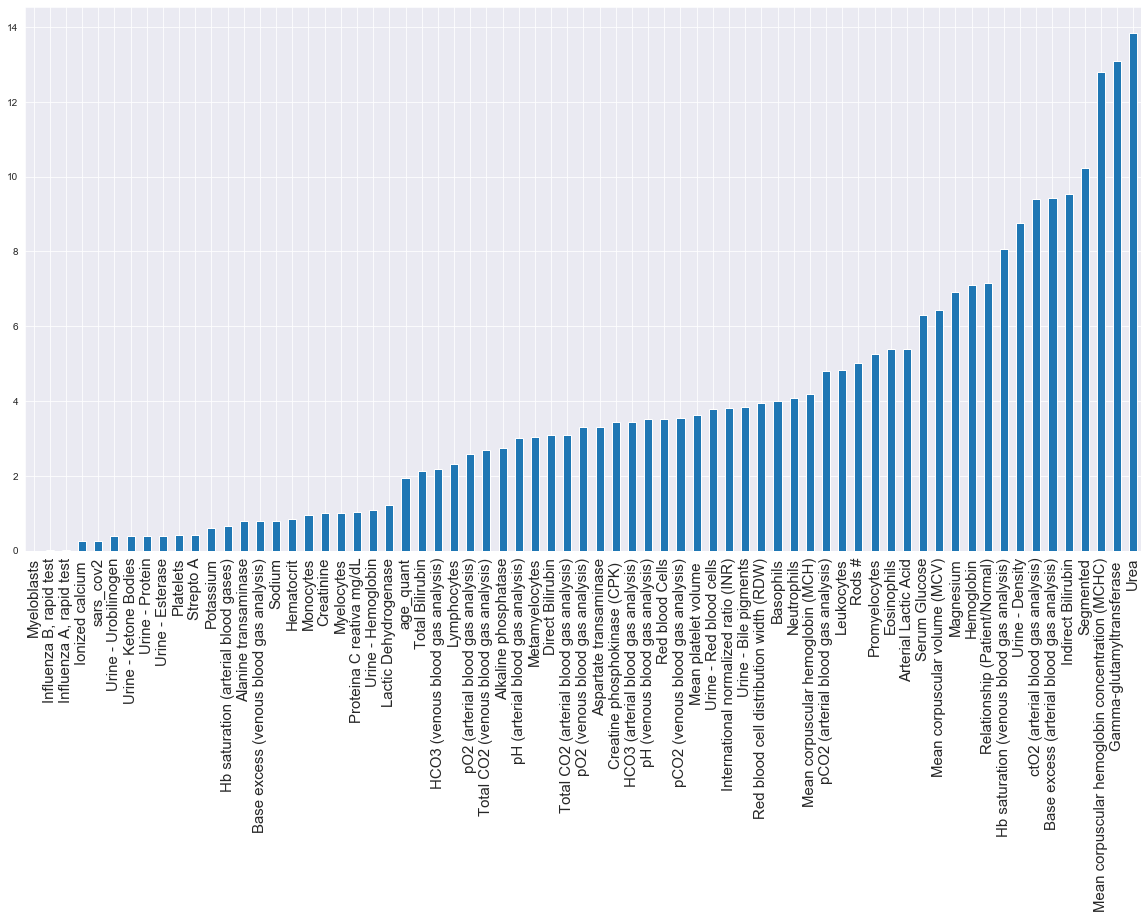

In [57]:
feature_ranks = pd.Series(abs(best_clf.coef_[0]), index=df2.drop('adm_status',axis=1).columns)
feature_ranks.sort_values(ascending=True,inplace=True)
fig,ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis='x',labelsize=15,labelrotation=45)
feature_ranks.plot(kind='bar',figsize=(20,10))
fig.savefig('feature_importance')

# Conclusion

It seems that Logistic Regression was our ideal model. It also seems that we were succesfully able to address the problem of imbalances classes by using SMOTE. We are able to identify 80% of the people who required admission to the intensive care unit, and 20% of people identified as requiring intensive care actually did not need intensive care. Our performance identifying people requiring admission to the regular ward is even better. Hopefully, these kinds of modeling techniques can help us direct limited medical resources to the people who need them the most. 